In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from unidip import UniDip
from sklearn.mixture import GaussianMixture

from clusterless import preprocess
from clusterless import viz
from clusterless import decoder

In [2]:
pid = 'febb430e-2d50-4f83-87a0-b5ffbb9a4943'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_009/2020-02-27/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'

load neural data

In [3]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

pid: febb430e-2d50-4f83-87a0-b5ffbb9a4943
eid: db4df448-e449-4a6f-a0e7-288711e7a75a
1st trial stim on time: 40.81, last trial stim on time 2252.10


In [4]:
n_trials = stim_on_times.shape[0]
n_channels = np1_channel_map.shape[0]

unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

In [5]:
behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = preprocess.preprocess_static_behaviors(behave_dict)

choices left: 0.361, right: 0.639
stimuli left: 0.430, right: 0.570
reward wrong: 0.087, correct: 0.913


thresholded decoding

In [6]:
thresholded_neural_data = data_preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

thresholded neural data shape: (230, 384, 30)


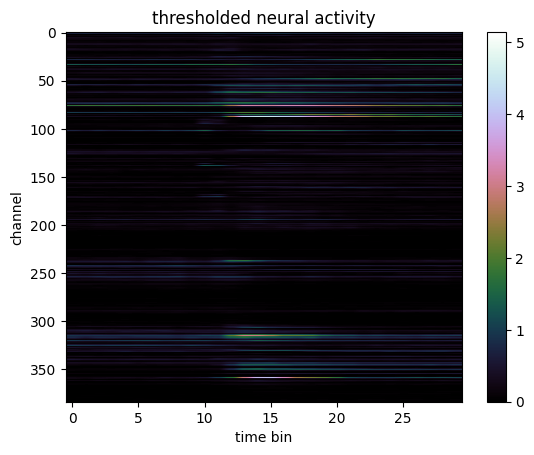

In [7]:
plt.imshow(thresholded_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('thresholded neural activity')
plt.xlabel('time bin')
plt.ylabel('channel')
plt.colorbar();

In [8]:
cv_accs, cv_aucs, _, _, _, _ = decode_static.cv_decode_static(thresholded_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, _, _, _, _ = decode_static.cv_decode_static(thresholded_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.957 auc: 0.998
choice fold 2 test accuracy: 1.000 auc: 1.000
choice fold 3 test accuracy: 0.957 auc: 0.996
choice fold 4 test accuracy: 0.957 auc: 0.984
choice fold 5 test accuracy: 0.935 auc: 0.988
choice mean of 5-fold cv accuracy: 0.961 auc: 0.993
choice sd of 5-fold cv accuracy: 0.021 auc: 0.006
stimulus fold 1 test accuracy: 0.370 auc: 0.787
stimulus fold 2 test accuracy: 0.413 auc: 0.874
stimulus fold 3 test accuracy: 0.413 auc: 0.835
stimulus fold 4 test accuracy: 0.435 auc: 0.832
stimulus fold 5 test accuracy: 0.522 auc: 0.863
stimulus mean of 5-fold cv accuracy: 0.430 auc: 0.838
stimulus sd of 5-fold cv accuracy: 0.050 auc: 0.030


clusterless decoding

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    '''
    https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
    '''
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def plot_MoG_bounds(
    data, 
    labels, 
    labels_display, 
    np1_channel_map,
    channels=[], 
    local=False,
    plot_MoG=False,
    n_spikes=5_000, 
    figure_size=(8,16), 
    title='', 
):
    '''
    '''
    fig, axes = plt.subplots(1, 2, figsize=figure_size) 
    colors = [k for k,v in pltc.cnames.items()]
    random.shuffle(colors)
    for idx in labels_display:
        c = int(idx)
        if idx >= len(colors):
            c = c // 6  # only 148 colors available for plotting
            
        sub_data = data[labels == idx]
        x, z, maxptp = sub_data.T
        
        if len(sub_data) <= 2:
            continue
            
        if plot_MoG:
            confidence_ellipse(x, z, axes[0], alpha=1., edgecolor=colors[c], linewidth=1., zorder=0)
            confidence_ellipse(maxptp, z, axes[1], alpha=1., edgecolor=colors[c], linewidth=1., zorder=0)
    
        if local:
            axes[0].scatter(x, z, s=.5, alpha=0.2, c=maxptp)
            axes[1].scatter(maxptp, z, s=.5, alpha=0.2, c=maxptp)
        else:
            axes[0].scatter(x[:n_spikes], z[:n_spikes], 
                            s=.5, alpha=0.05, c=maxptp[:n_spikes])
            axes[1].scatter(maxptp[:n_spikes], z[:n_spikes], 
                            s=.5, alpha=0.05, c=maxptp[:n_spikes])
            
        if local:
            axes[0].set_xlim(x.min()-25, x.max()+25)
            axes[0].set_ylim(z.min()-25, z.max()+25)
            axes[1].set_xlim(0, maxptp.max()+25)
            axes[1].set_ylim(z.min()-25, z.max()+25)
        else:    
            axes[0].set_xlim(-100, 175)
            axes[0].set_ylim(-80, 4000)
            axes[1].set_xlim(0, 60)
            axes[1].set_ylim(-80, 4000)
        
    if len(channels) > 0: 
        for channel in channels:
            axes[0].plot(np1_channel_map[int(channel), 0], 
                         np1_channel_map[int(channel), 1], 
                         markersize=3, c='orange', marker="s")
                
    axes[0].set_xlabel('x (um)')
    axes[0].set_ylabel('z (um)')
    axes[0].set_title(f'{title}')
    axes[1].set_xlabel('max ptp (amp)')
    axes[1].set_ylabel('z (um)')
    if plot_MoG:
        axes[1].set_title(f'n_units = {len(np.unique(labels_display))}')

    for ax in ['top','bottom','left','right']:
        axes[0].spines[ax].set_linewidth(1.5)
        axes[1].spines[ax].set_linewidth(1.5)

    plt.tight_layout()
    # plt.show()
    plt.savefig('./our_localizations.png', dpi=600)

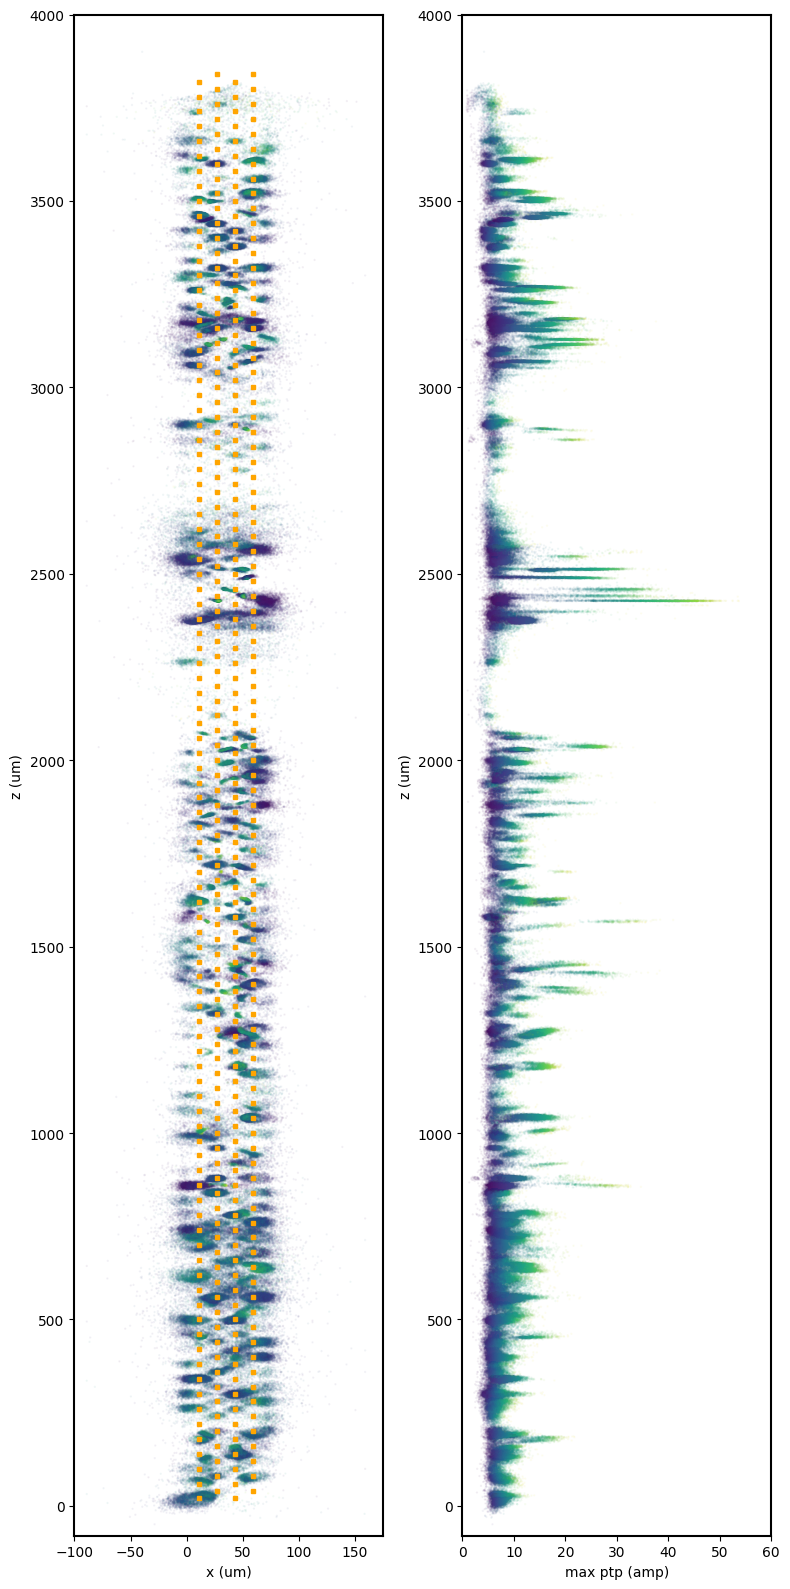

In [7]:
plot_MoG_bounds(
    data=spike_features, 
    labels=spike_channels, 
    labels_display=np.arange(n_channels), 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels),
)

model selection

In [7]:
sample_spikes = [trial[np.random.choice(len(trial), 300), 2:] for trial in unsorted_trials]
sample_spikes = np.vstack(sample_spikes)
print(sample_spikes.shape)

(69000, 3)


In [10]:
lowest_bic = np.infty
bic = []
k_range = range(100, 384, 10)

for k in k_range:
    print(f'--- fit MoG with {k} gaussians ---')
    gmm = GaussianMixture(
        init_params='kmeans',
        n_components=k, covariance_type='full',
        random_state=seed, warm_start=False, 
        verbose=1, 
        verbose_interval=5
    )
    gmm.fit(sample_spikes)
    bic.append(gmm.bic(sample_spikes))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_bic_gmm = gmm
    print(f'current bic: {round(bic[-1],2)}')
    print(f'best bic MoG has {len(best_bic_gmm.weights_)} gaussians.')

--- fit MoG with 100 gaussians ---
Initialization 0
  Iteration 5
  Iteration 10
  Iteration 15
  Iteration 20
  Iteration 25
  Iteration 30
  Iteration 35
Initialization converged: True
current bic: 1889193.52
best bic MoG has 100 gaussians.
--- fit MoG with 110 gaussians ---
Initialization 0
  Iteration 5
  Iteration 10
  Iteration 15
  Iteration 20
  Iteration 25
  Iteration 30
  Iteration 35
Initialization converged: True
current bic: 1885001.01
best bic MoG has 110 gaussians.
--- fit MoG with 120 gaussians ---
Initialization 0
  Iteration 5
  Iteration 10
  Iteration 15
  Iteration 20
  Iteration 25
  Iteration 30
  Iteration 35
  Iteration 40
Initialization converged: True
current bic: 1878504.04
best bic MoG has 120 gaussians.
--- fit MoG with 130 gaussians ---
Initialization 0
  Iteration 5
  Iteration 10
  Iteration 15
  Iteration 20
  Iteration 25
  Iteration 30
  Iteration 35
Initialization converged: True
current bic: 1873408.57
best bic MoG has 130 gaussians.
--- fit MoG w

In [13]:
best_bic_gmm = GaussianMixture(
        init_params='kmeans',
        n_components=330,
        covariance_type='full',
        random_state=seed, 
        warm_start=False, 
        verbose=1, 
        verbose_interval=1
    ).fit(spike_features)

Initialization 0
  Iteration 1
  Iteration 2
  Iteration 3
  Iteration 4
  Iteration 5
  Iteration 6
  Iteration 7
  Iteration 8
  Iteration 9
  Iteration 10
  Iteration 11
  Iteration 12
  Iteration 13
  Iteration 14
  Iteration 15
  Iteration 16
  Iteration 17
  Iteration 18
  Iteration 19
  Iteration 20
  Iteration 21
  Iteration 22
  Iteration 23
  Iteration 24
Initialization converged: True


In [14]:
spike_labels = []
spike_probs = []
offset = 100_000
for i in range(5):
    print(f'load batch {i} ..')
    spike_labels.extend(best_bic_gmm.predict(spike_features[i*offset:(i+1)*offset]))
    spike_probs.extend(best_bic_gmm.predict_proba(spike_features[i*offset:(i+1)*offset]))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

load batch 0 ..
load batch 1 ..
load batch 2 ..
load batch 3 ..
load batch 4 ..


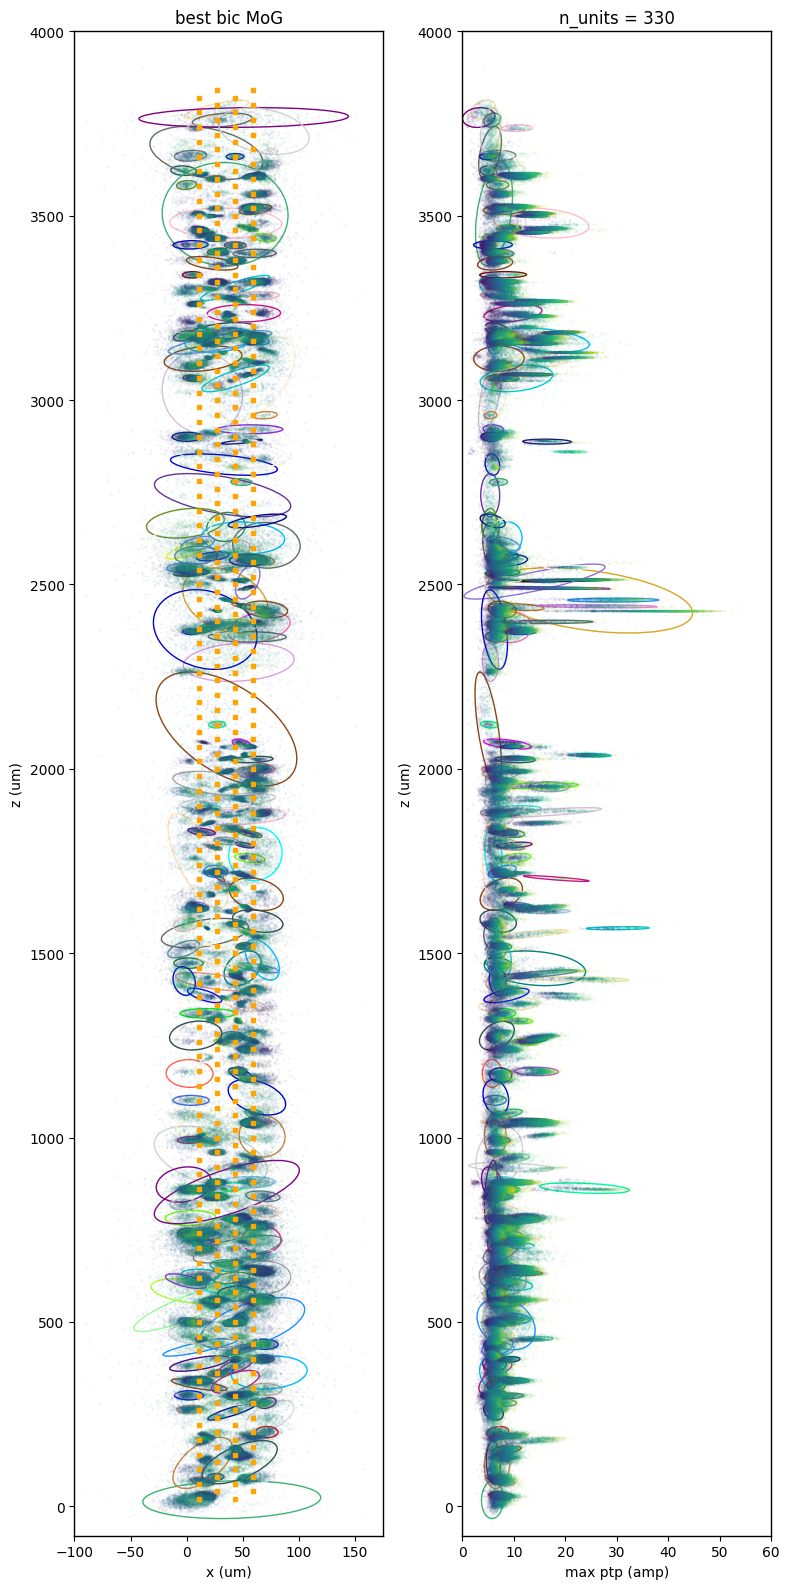

In [15]:
viz.plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=np.unique(spike_labels), 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels),
    plot_MoG=True,
    title='best bic MoG'
)

In [16]:
clusterless_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (230, 330, 30)


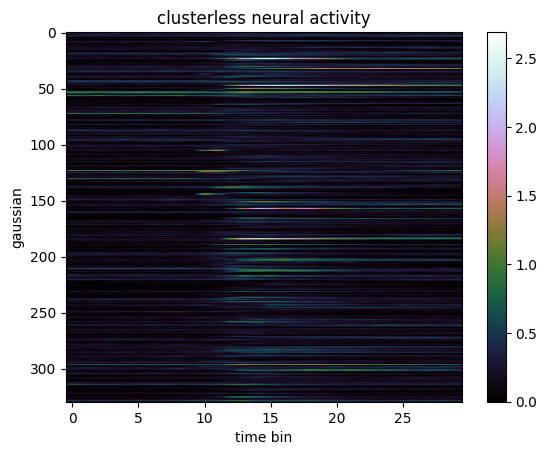

In [17]:
plt.imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('clusterless neural activity')
plt.xlabel('time bin')
plt.ylabel('gaussian')
plt.colorbar();

In [18]:
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.935 auc: 0.996
choice fold 2 test accuracy: 0.978 auc: 1.000
choice fold 3 test accuracy: 0.957 auc: 0.998
choice fold 4 test accuracy: 0.935 auc: 0.976
choice fold 5 test accuracy: 0.935 auc: 0.990
choice mean of 5-fold cv accuracy: 0.948 auc: 0.992
choice sd of 5-fold cv accuracy: 0.017 auc: 0.009
stimulus fold 1 test accuracy: 0.391 auc: 0.797
stimulus fold 2 test accuracy: 0.522 auc: 0.858
stimulus fold 3 test accuracy: 0.457 auc: 0.841
stimulus fold 4 test accuracy: 0.435 auc: 0.822
stimulus fold 5 test accuracy: 0.500 auc: 0.866
stimulus mean of 5-fold cv accuracy: 0.461 auc: 0.837
stimulus sd of 5-fold cv accuracy: 0.046 auc: 0.025


In [19]:
gmm_name = '../pretrained/danlab/Subjects/DY_009/best_bic_gmm'
np.save(gmm_name + '_weights', best_bic_gmm.weights_, allow_pickle=False)
np.save(gmm_name + '_means', best_bic_gmm.means_, allow_pickle=False)
np.save(gmm_name + '_covariances', best_bic_gmm.covariances_, allow_pickle=False)

np.save('../pretrained/danlab/Subjects/DY_009/best_bic_gmm_spike_train.npy', np.c_[spike_times, spike_labels, spike_probs])

In [20]:
del best_bic_gmm
del spike_labels
del spike_probs

distributed MoG using max channel (split-merge)

In [17]:
multi_modal_channels = {}
sub_weights_lst = []
sub_means_lst = []
sub_covs_lst = []
alpha = 0.01
for channel in np.unique(spike_channels):
    sub_spike_features = spike_features[spike_channels == channel]
    sub_x, sub_z, sub_maxptp = sub_spike_features.T
    # a minimum of 2 points required for MoG
    if len(sub_spike_features) > 2: 
        n_modes_x = len(UniDip(sub_x, alpha = alpha).run())
        n_modes_z = len(UniDip(sub_z, alpha = alpha).run())
        n_modes_ptp = len(UniDip(sub_maxptp, alpha = alpha).run())
        n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])
        if n_gaussians == 0:
            n_gaussians = 1
        if n_gaussians > 1:
            print(f'channel {channel} has {n_gaussians} modes ...')
            multi_modal_channels.update({channel: n_gaussians})
        if n_gaussians >= 1:
            sub_gmm = GaussianMixture(n_components=n_gaussians, 
                              max_iter=1000,
                              covariance_type='full',
                              init_params='kmeans', 
                              warm_start=False, 
                              verbose=0)
            sub_gmm.fit(sub_spike_features)
            sub_labels = sub_gmm.predict(sub_spike_features)
            sub_weights = [np.sum(sub_labels == i)/len(spike_features) for i in range(n_gaussians)]
            sub_weights_lst.append(sub_weights)
            sub_means_lst.append(sub_gmm.means_)
            sub_covs_lst.append(sub_gmm.covariances_)
sub_weights = np.hstack(sub_weights_lst)
sub_means = np.vstack(sub_means_lst)
sub_covs = np.vstack(sub_covs_lst)

channel 38.0 has 4 modes ...
channel 39.0 has 2 modes ...
channel 45.0 has 2 modes ...
channel 62.0 has 3 modes ...
channel 69.0 has 2 modes ...
channel 78.0 has 2 modes ...
channel 84.0 has 2 modes ...
channel 85.0 has 6 modes ...
channel 91.0 has 2 modes ...
channel 99.0 has 2 modes ...
channel 101.0 has 2 modes ...
channel 116.0 has 4 modes ...
channel 124.0 has 4 modes ...
channel 126.0 has 4 modes ...
channel 130.0 has 2 modes ...
channel 132.0 has 2 modes ...
channel 134.0 has 2 modes ...
channel 136.0 has 2 modes ...
channel 138.0 has 2 modes ...
channel 140.0 has 2 modes ...
channel 142.0 has 5 modes ...
channel 143.0 has 3 modes ...
channel 144.0 has 2 modes ...
channel 145.0 has 2 modes ...
channel 155.0 has 2 modes ...
channel 157.0 has 3 modes ...
channel 159.0 has 2 modes ...
channel 160.0 has 3 modes ...
channel 162.0 has 2 modes ...
channel 166.0 has 2 modes ...
channel 168.0 has 3 modes ...
channel 172.0 has 2 modes ...
channel 173.0 has 2 modes ...
channel 174.0 has 2 

In [18]:
post_split_gmm = GaussianMixture(n_components=len(sub_weights), 
                                 covariance_type='full')
post_split_gmm.weights_ = sub_weights
post_split_gmm.means_ = sub_means
post_split_gmm.covariances_ = sub_covs
post_split_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(sub_covs))

In [7]:
# gmm_name = '../pretrained/danlab/Subjects/DY_009/init_max_chan_gmm'
# means = np.load(gmm_name + '_means.npy')
# covar = np.load(gmm_name + '_covariances.npy')
# loaded_gmm = GaussianMixture(n_components=len(means), covariance_type='full')
# loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
# loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
# loaded_gmm.means_ = means
# loaded_gmm.covariances_ = covar

In [11]:
len(spike_features)

493156

In [20]:
spike_labels = []
spike_probs = []
offset = 100_000
for i in range(5):
    print(f'loading batch {i+1}')
    spike_labels.extend(post_split_gmm.predict(spike_features[i*offset:(i+1)*offset]))
    spike_probs.extend(post_split_gmm.predict_proba(spike_features[i*offset:(i+1)*offset]))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

loading batch 1
loading batch 2
loading batch 3
loading batch 4
loading batch 5


In [21]:
# np.save('../pretrained/danlab/Subjects/DY_009/spike_channels.npy', spike_channels)
# np.save('../pretrained/danlab/Subjects/DY_009/spike_features.npy', spike_features)
# np.save('../pretrained/danlab/Subjects/DY_009/multi_modal_channels.npy', multi_modal_channels)
# np.save('../pretrained/danlab/Subjects/DY_009/gmm_spike_train.npy', np.c_[spike_times, spike_labels, spike_probs])

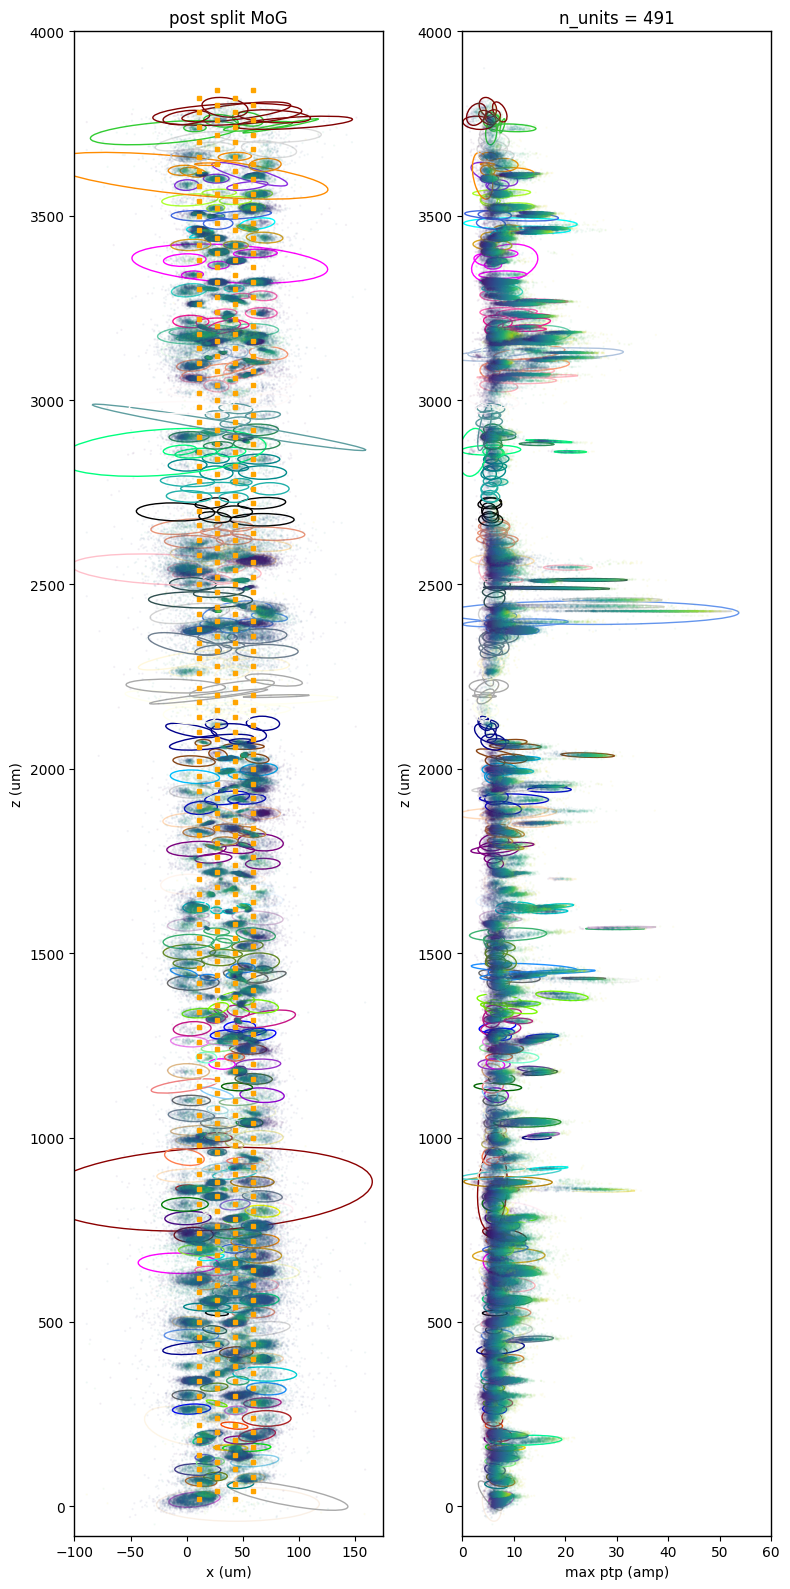

In [23]:
viz.plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=np.unique(spike_labels), 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels),
    plot_MoG=True,
    title='post split MoG'
)

In [25]:
clusterless_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (230, 491, 30)


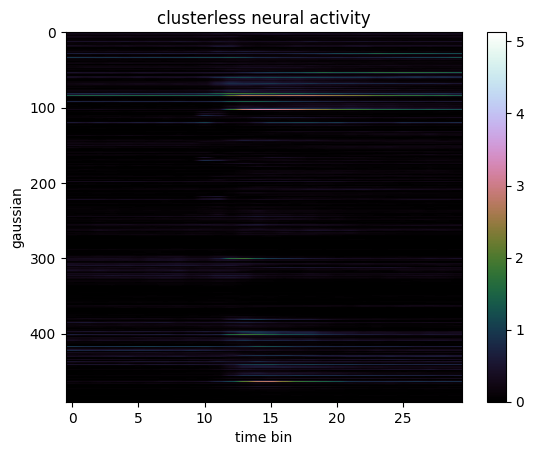

In [26]:
plt.imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('clusterless neural activity')
plt.xlabel('time bin')
plt.ylabel('gaussian')
plt.colorbar();

In [32]:
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(
    clusterless_neural_data, 
    choices, 
    behave_type='choice', 
    n_folds=5, 
    seed=seed, 
    shuffle=True
)

choice fold 1 test accuracy: 0.978 auc: 0.998
choice fold 2 test accuracy: 1.000 auc: 1.000
choice fold 3 test accuracy: 0.978 auc: 0.998
choice fold 4 test accuracy: 0.935 auc: 0.986
choice fold 5 test accuracy: 0.913 auc: 0.988
choice mean of 5-fold cv accuracy: 0.961 auc: 0.994
choice sd of 5-fold cv accuracy: 0.032 auc: 0.006


In [33]:
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(
    clusterless_neural_data, 
    one_hot_stimuli, 
    behave_type='stimulus', 
    n_folds=5, 
    seed=seed, 
    shuffle=True
)

stimulus fold 1 test accuracy: 0.348 auc: 0.785
stimulus fold 2 test accuracy: 0.478 auc: 0.869
stimulus fold 3 test accuracy: 0.435 auc: 0.841
stimulus fold 4 test accuracy: 0.478 auc: 0.831
stimulus fold 5 test accuracy: 0.522 auc: 0.870
stimulus mean of 5-fold cv accuracy: 0.452 auc: 0.839
stimulus sd of 5-fold cv accuracy: 0.059 auc: 0.031


In [19]:
# gmm_name = '../pretrained/danlab/Subjects/DY_009/init_max_chan_gmm'
# np.save(gmm_name + '_weights', post_split_gmm.weights_, allow_pickle=False)
# np.save(gmm_name + '_means', post_split_gmm.means_, allow_pickle=False)
# np.save(gmm_name + '_covariances', post_split_gmm.covariances_, allow_pickle=False)

In [31]:
del post_split_gmm
del spike_labels
del spike_probs